# Parking Robot with Discrete Dynamics
Richard  M. Murray, 20 Jul 2013 (updated 19 Feb 2020)

## Problem description
This example illustrates the use of TuLiP to synthesize a reactive
controller for system whose dynamics are described by a discrete
transition system.

We begin by importing the packages and modules that we will need.

In [2]:
# Include commands to allow inline display of movies
%matplotlib inline
from IPython.display import HTML

# Import TuLiP and other Python packages
from tulip import transys, spec, synth
import random

### System dynamics

The system is modeled as a discrete transition system in which the
robot can be located anyplace on a 2x3 grid of cells.  Transitions
between adjacent cells are allowed, which we model as a transition
system in this example (it would also be possible to do this via a
formula).

We label the states using the following picture:

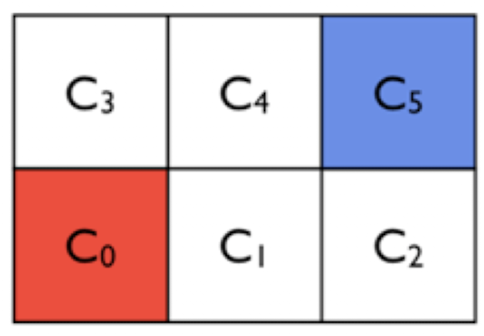

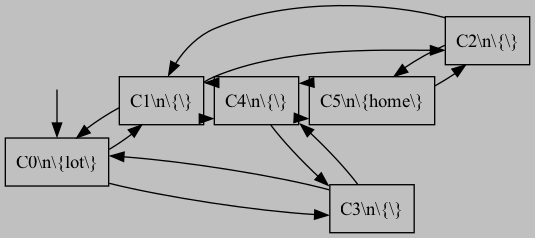

True

In [4]:
# Create a finite transition system
sys = transys.FTS()

# Define the states of the system
sys.states.add_from(['C0', 'C1', 'C2', 'C3', 'C4', 'C5'])
sys.states.initial.add_from(['C0'])    # start in state C0

# Define the allowable transitions
sys.transitions.add_comb({'C0'}, {'C1', 'C3'})
sys.transitions.add_comb({'C1'}, {'C0', 'C4', 'C2'})
sys.transitions.add_comb({'C2'}, {'C1', 'C5'})
sys.transitions.add_comb({'C3'}, {'C0', 'C4'})
sys.transitions.add_comb({'C4'}, {'C3', 'C1', 'C5'})
sys.transitions.add_comb({'C5'}, {'C4', 'C2'})

# Add atomic propositions to the states
sys.atomic_propositions.add_from({'home', 'lot'})
sys.states.add('C0', ap={'lot'})
sys.states.add('C5', ap={'home'})

# Generate a picture of the system
sys.plot()

### Environment variables and specification

The environment can issue a park signal that the robot must respond
to by moving to the lower left corner of the grid.  We assume that
the park signal is turned off infinitely often.

In [5]:
env_vars = {'park'}
env_init = []                   # empty set
env_prog = '!park'
env_safe = set()                # empty set (another way)

### System specification

The system specification is that the robot should repeatedly revisit
the upper right corner of the grid while at the same time responding
to the park signal by visiting the lower left corner.  The LTL
specification is given by

    []<> home && [](park -> <>lot)

Since this specification is not in GR(1) form, we introduce the
variable X0reach that is initialized to True and the specification
`[](park -> <>lot)` becomes

    []((X (X0reach)) <-> (lot | (X0reach && !park)))

In [6]:
sys_vars = {'X0reach'}          # infer the rest from TS
sys_init = {'X0reach'}
sys_prog = {'home'}             # []<>home
sys_safe = {'(X (X0reach)) <-> (lot | (X0reach & !park))'}
sys_prog |= {'X0reach'}

In [7]:
# Create the specification
specs = spec.GRSpec(env_vars, sys_vars, env_init, sys_init,
                    env_safe, sys_safe, env_prog, sys_prog)
specs.qinit = "\A \E"
print(specs.pretty())

ENVIRONMENT VARIABLES:
	park	boolean

SYSTEM VARIABLES:
	X0reach	boolean

FORMULA:
ASSUMPTION:
    LIVENESS
	  []<>(!park)
GUARANTEE:
    INITIAL
	  (X0reach)
    SAFETY
	  []((X (X0reach)) <-> (lot | (X0reach & !park)))
    LIVENESS
	  []<>(home)
	& []<>(X0reach)



## Controller synthesis

At this point we can synthesize the controller using one of the available
methods.

In [8]:
ctrl = synth.synthesize(specs, sys=sys)
assert ctrl is not None, 'unrealizable'

removed 0 nodes from 23 total


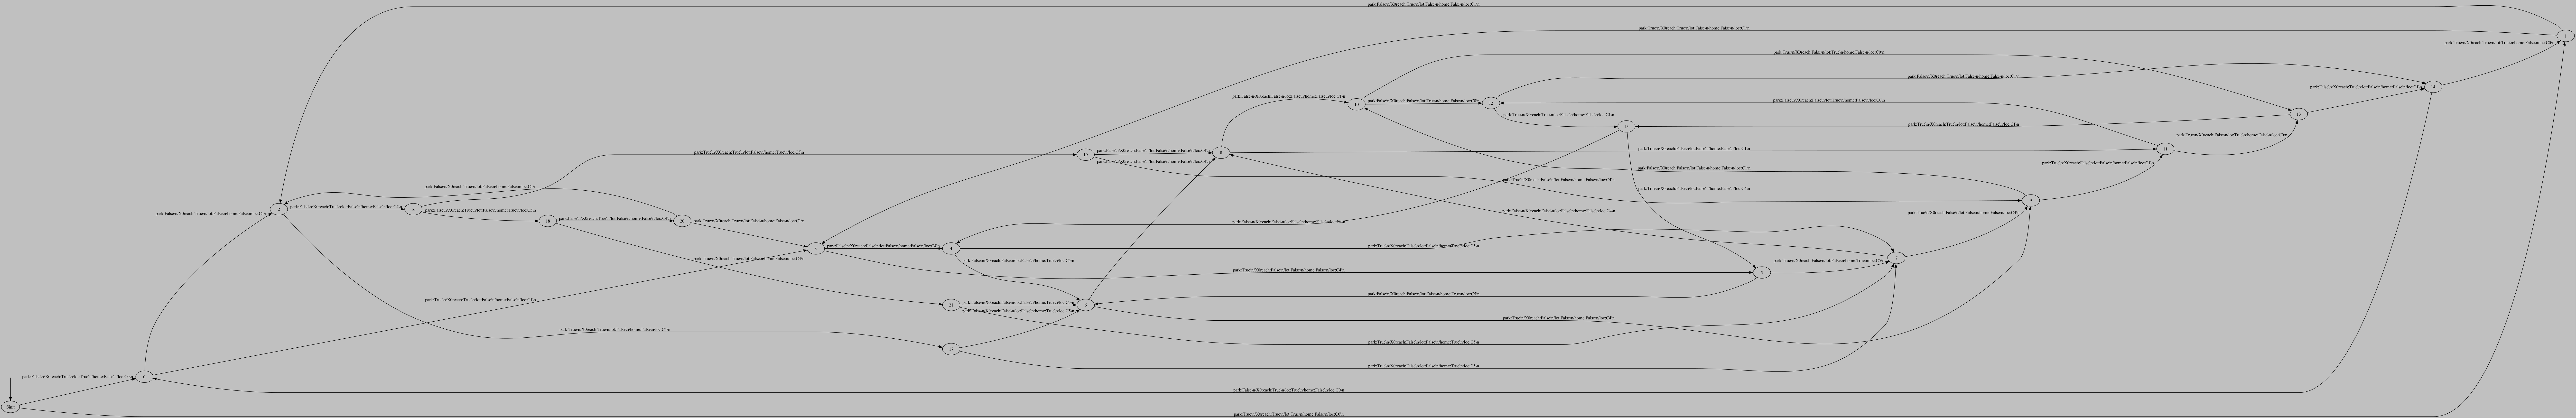

----------------------------------------
Mealy Machine: 
----------------------------------------
State Variables:
	(name : type)

States & State Var Values:
	0 :

	1 :

	2 :

	3 :

	4 :

	5 :

	6 :

	7 :

	8 :

	9 :

	10 :

	11 :

	12 :

	13 :

	14 :

	15 :

	16 :

	17 :

	18 :

	19 :

	20 :

	21 :

	Sinit :

Initial States:
SubSet(['Sinit'])

Input Ports:
	(name : type)
	park : {0, 1}

Output Ports:
	(name : type)
	X0reach : {0, 1}
	lot : {0, 1}
	home : {0, 1}
	loc : {'C1', 'C2', 'C5', 'C3', 'C4', 'C0'}

Transitions & Labels: (from --> to : label)
	0 ---> 2 :
		park : False
		X0reach : True
		lot : False
		home : False
		loc : C1

	0 ---> 3 :
		park : True
		X0reach : True
		lot : False
		home : False
		loc : C1

	1 ---> 2 :
		park : False
		X0reach : True
		lot : False
		home : False
		loc : C1

	1 ---> 3 :
		park : True
		X0reach : True
		lot : False
		home : False
		loc : C1

	2 ---> 16 :
		park : False
		X0reach : True
		lot : False
		home : False
		loc : C4

	2 ---> 17 :
		park 

In [9]:
# Description of the synthesized controller
ctrl.plot()
print(ctrl)

## Simulation

We can now generate a simulation to visualize the action of the controller.

Note: this simulation uses the `gridworld` module functionality to generate the animation.  This is not ideal for this example, but is a good first start.

In [10]:
# Create a grid world for visualizing the results
import tulip.gridworld as gw
world = gw.unoccupied((2, 3))
print(world)

# Create a dictionary between named locations and gridworld location
gridloc = {
    'C3': (0, 0), 'C4': (0, 1), 'C5': (0, 2),
    'C0': (1, 0), 'C1': (1, 1), 'C2': (1, 2)
}

   0 1 2
  -------
 0| | | |
  -------
 1| | | |
  -------



In [11]:
# Simulation
T = 100

# Pick an environmental signal
# randParkSignal = [random.randint(0, 1) for b in range(1, T + 1)]
randParkSignal = [(0, 0, 0, 0, 0, 0, 0, 1)[b % 8] for b in range(1, T+1)]

# Run a simulation
time, states = ctrl.run('Sinit', {'park': randParkSignal})

# Grab the location
loc = [gridloc[loc] for loc in states['loc']]

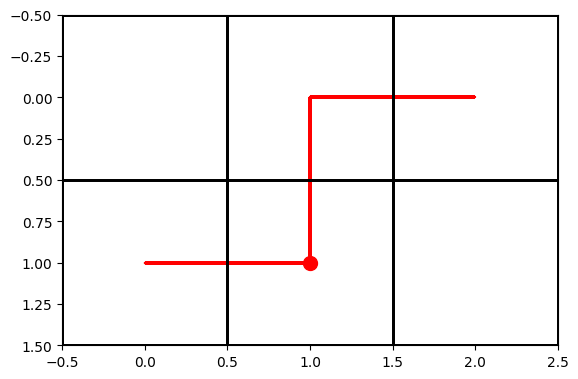

In [12]:
# Animate the motion
anim = gw.animate_paths(world, (loc,))
HTML(anim.to_jshtml())

## Things to Try
* Allow the system to start in a different state
* Allow the system to stay in its current cell for multiple steps

## specs.qinit

* '\A \A': forall env forall sys assume env_init sys_init must be empty
* '\A \E': forall env exist sys (usually not Moore) assume env_init and require sys_init
* '\E \A': exist sys forall env assume env_init and require sys_init
* '\E \E': exist env exist sys require sys_init env_init must be empty